This notebook is for exploratory analysis of COVID-19 Radiography database from Kaggle : https://www.kaggle.com/tawsifurrahman/covid19-radiography-datab
ase


In [ ]:
import os
import random
from collections import defaultdict
from glob import glob
from math import pi
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import Parallel, delayed
from skimage.feature import graycomatrix, graycoprops
from tqdm.auto import tqdm

# CHEMINS ET CHARGEMENT DES DONNEES

## CHEMINS

In [ ]:
# @title VARIABLES DE SESSION
# @markdown
DATA_ROOT = "../data"  # @param {type: "string"}
# @markdown ---

In [ ]:
DATA_ROOT = Path(DATA_ROOT)
RAW_DATA = DATA_ROOT / "01_raw/COVID-19_Radiography_Dataset"
REPS = ["COVID", "Lung_Opacity", "Viral Pneumonia", "Normal"]

In [ ]:
# TODO (Done): taille des images, canaux, nombre,
# TODO (All): Tester l'environnement de travail
# TODO (Yeyecodes): Appliquer les masques et refaire haraclick, moyenne des pixels,
# TODO (Yeyecodes & CedrickArmel): interprétation Haralickpuis
# TODO (TaxelleT & CedrickArmel): calculer l'aire des poumons. Gauche versus droite
# TODO (CedrickArmel): Explorer si la maladie ne concerne qu'une seule partie du poumon.
# TODO (CedrickArmel): équilibrer les classes, normaliser , rétirer les outlines, mettre les masques,
# TODO (TaxelleT & CedrickArmel): Appliquer pour mettre en évidence les files, cables

# TODO: data augmentation pour gérer les conditions de prise de vue
# TODO: Appliquer pour mettre en évidence les files, cables

## CHARGEMENT DES DONNES

In [ ]:
metadata = pd.concat(
    [pd.read_excel(file) for file in glob(os.path.join(RAW_DATA, "*.metadata.xlsx"))]
)
metadata.columns = ["file_name", "format", "size", "url"]

In [ ]:
images = defaultdict()
masks: defaultdict = defaultdict()

In [ ]:
print(
    f"Unique files format in `{RAW_DATA}` subfolders :",
    set([Path(f).suffix for f in glob(str(RAW_DATA / "**/**/*"))]),
)

Unique files format in `..\data\01_raw\COVID-19_Radiography_Dataset` subfolders : {'.png'}


> All files in the subfolders of `RAW_DATA` are PNG images.

In [ ]:
for rep in REPS:
    images[rep.lower().replace(" ", "_")] = [
        cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        for f in glob(str(RAW_DATA / rep / "images/*.png"))
    ]

    masks[rep.lower().replace(" ", "_")] = [
        cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        for f in glob(str(RAW_DATA / rep / "masks/*.png"))
    ]

In [ ]:
print(images.keys())

dict_keys(['covid', 'lung_opacity', 'viral_pneumonia', 'normal'])


In [ ]:
print(masks.keys())

dict_keys(['covid', 'lung_opacity', 'viral_pneumonia', 'normal'])


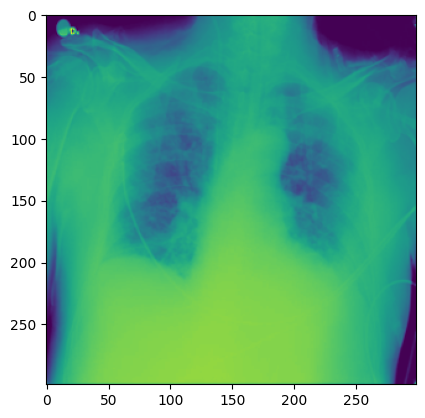

In [ ]:
plt.imshow(images["covid"][0])
plt.show()

Par exemple pour accéder aux images de la catégorie COVID, faire:
```python
covid_images: list[np.ndarray] = images["covid"]
```
`cv2.IMREAD_GRAYSCALE` pour charger les images en niveaux de gris (une seule bande).

# EXPLORATION DES DONNEES

## EDA

### Analyse des métadonnées

# Calcul de l'air des poumons

Dans cette partie on cherche à voir si il y e un lien entre l'aire des poumons et le fait d'être malade

## Partie 1 : Analyse de l'aire des poumons sains
question : est ce que une paire de poumons sain, à deux poumons identiques?

In [ ]:
import cv2
import numpy as np

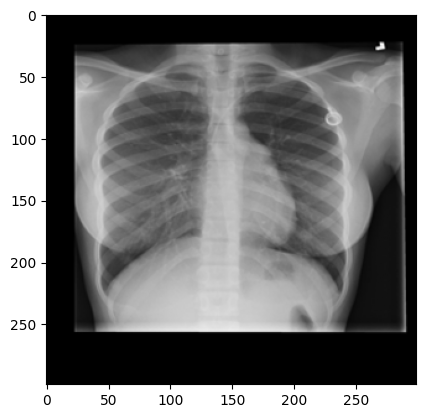

In [ ]:
im = images["normal"][0]
plt.imshow(im, cmap="gray")

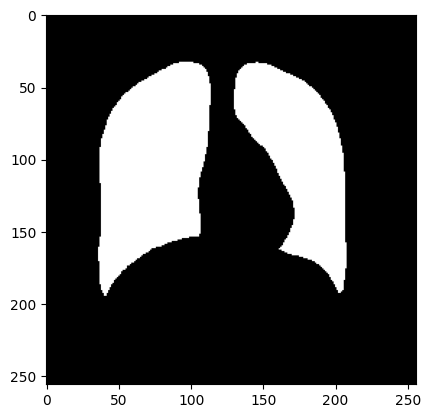

In [ ]:
mask = masks["normal"][0]  # un masque
binary_mask = (mask > 0).astype(np.uint8)
plt.imshow(binary_mask, cmap="gray")

Je compte le nombre de pixel pour le poumons gauche et droit d'un masque de la classe "normal" et je compare

In [ ]:
num_labels, labels = cv2.connectedComponents(binary_mask)
areas = {}

for label in range(1, num_labels):
    areas[label] = np.sum(labels == label)
print(areas)

lung_labels = sorted(areas, key=areas.get, reverse=True)[:2]

centers_x = {}

for label in lung_labels:
    ys, xs = np.where(labels == label)
    centers_x[label] = xs.mean()

left_lung = min(centers_x, key=centers_x.get)
right_lung = max(centers_x, key=centers_x.get)

left_area = areas[left_lung]
right_area = areas[right_lung]
total_area = left_area + right_area
print(f"Aire poumon gauche : {left_area} pixels ({left_area/total_area:.2%})")
print(f"Aire poumon droit : {right_area} pixels ({right_area/total_area:.2%})")

{1: np.int64(8730), 2: np.int64(6681)}
Aire poumon gauche : 8730 pixels (56.65%)
Aire poumon droit : 6681 pixels (43.35%)


In [ ]:
print(num_labels)
print(labels.shape)

3
(256, 256)


In [ ]:
print(labels[100, 2])

0


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

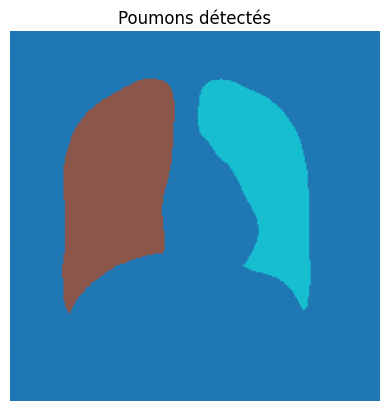

In [ ]:
plt.imshow(labels, cmap="tab10")
plt.title("Poumons détectés")
plt.axis("off")

Cette fois ci je compare les nombre de pixels entre poumons gauche et droit de tous les masque de la classe "normal"

In [ ]:
def lung_areas_from_mask(mask):
    # 1. binarisation
    binary_mask = (mask > 0).astype(np.uint8)

    # 2. composantes connexes
    num_labels, labels = cv2.connectedComponents(binary_mask)

    # 3. aire de chaque composante
    areas = {}
    for label in range(1, num_labels):
        areas[label] = np.sum(labels == label)

    # 4. garder les deux plus grandes (poumons)
    lung_labels = sorted(areas, key=areas.get, reverse=True)[:2]

    # 5. centres horizontaux
    centers_x = {}
    for label in lung_labels:
        ys, xs = np.where(labels == label)
        centers_x[label] = xs.mean()

    # 6. gauche / droite
    left_label = min(centers_x, key=centers_x.get)
    right_label = max(centers_x, key=centers_x.get)

    return areas[left_label], areas[right_label]

In [ ]:
left_areas = []
right_areas = []
diff_areas = []

for mask in masks["normal"]:
    left_area, right_area = lung_areas_from_mask(mask)

    left_areas.append(left_area)
    right_areas.append(right_area)
    diff_areas.append(abs(left_area - right_area))

In [ ]:
diff_areas = np.array(diff_areas)

mean_diff = diff_areas.mean()
median_diff = np.median(diff_areas)
std_diff = diff_areas.std()

print(f"Différence moyenne : {mean_diff:.2f} pixels")
print(f"Différence médiane : {median_diff:.2f} pixels")
print(f"Écart-type : {std_diff:.2f} pixels")

Différence moyenne : 1424.15 pixels
Différence médiane : 1339.50 pixels
Écart-type : 798.21 pixels


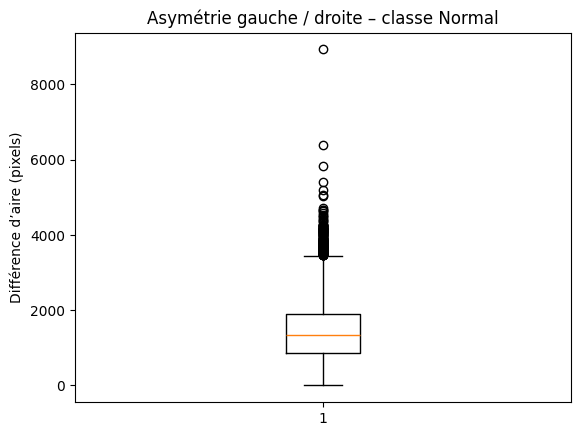

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot(diff_areas, vert=True)
plt.ylabel("Différence d’aire (pixels)")
plt.title("Asymétrie gauche / droite – classe Normal")
plt.show()

Je me dis que le nombre de pixel brute n'est pas une bonne métrique pour comprarer et faire des statistique sur toute une classe.
Je met donc en place un indice d'asymétrie 

Indice d’asymétrie pulmonaire

L’indice d’asymétrie permet de quantifier la différence relative de taille entre le poumon gauche et le poumon droit à partir de leurs aires segmentées.

Il est défini comme :

Indice d’asymétrie = |Ag - Ad|/Ag + Ad

Cet indice est sans unité, borné entre 0 et 1, et indépendant de la résolution ou de l’échelle de l’image, ce qui le rend robuste aux variations de distance ou de zoom lors de l’acquisition des radiographies.

Une valeur proche de 0 indique une forte symétrie pulmonaire, tandis qu’une valeur élevée traduit une asymétrie plus marquée, pouvant être associée à certaines pathologies pulmonaires.



## calcul de l'indice d'asymétrie pour un masque

In [ ]:
mask = masks["normal"][0]
_, binary = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
num_labels, labels = cv2.connectedComponents(binary)

areas = {}

for label in range(1, num_labels):
    areas[label] = np.sum(labels == label)

lung_labels = sorted(areas, key=areas.get, reverse=True)[:2]

area_1 = areas[lung_labels[0]]
area_2 = areas[lung_labels[1]]

asymmetry_index = abs(area_1 - area_2) / (area_1 + area_2)

print(f"Indice d'asymétrie : {asymmetry_index:.3f}")

Indice d'asymétrie : 0.133


## calculer l’indice d’asymétrie pour tous les masques de la classe normal

In [ ]:
def compute_asymmetry_for_class(mask_list):
    asymmetry_indices = []
    for mask in mask_list:
        # Binarisation
        _, binary = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
        # Composantes connexes
        num_labels, labels = cv2.connectedComponents(binary)
        # Aires des composantes
        areas = {}
        for label in range(1, num_labels):
            areas[label] = np.sum(labels == label)
        # On garde les deux plus grandes (les poumons)
        lung_labels = sorted(areas, key=areas.get, reverse=True)[:2]
        if len(lung_labels) < 2:
            # Not enough regions, assign asymmetry score of 1
            asymmetry_indices.append(1)
            continue
        area_1 = areas[lung_labels[0]]
        area_2 = areas[lung_labels[1]]
        # Indice d’asymétrie
        ai = abs(area_1 - area_2) / (area_1 + area_2)
        asymmetry_indices.append(ai)
    return np.array(asymmetry_indices)

In [ ]:
normal_asymmetry = compute_asymmetry_for_class(masks["normal"])

In [ ]:
mean_norm_ai = np.mean(normal_asymmetry)
median_norm_ai = np.median(normal_asymmetry)
std_norm_ai = np.std(normal_asymmetry)
min_norm_ai = np.min(normal_asymmetry)
max_norm_ai = np.max(normal_asymmetry)

print(f"Moyenne : {mean_norm_ai:.3f}")
print(f"Médiane : {median_norm_ai:.3f}")
print(f"Écart-type : {std_norm_ai:.3f}")
print(f"Min : {min_norm_ai:.3f}")
print(f"Max : {max_norm_ai:.3f}")

Moyenne : 0.090
Médiane : 0.082
Écart-type : 0.055
Min : 0.000
Max : 0.977


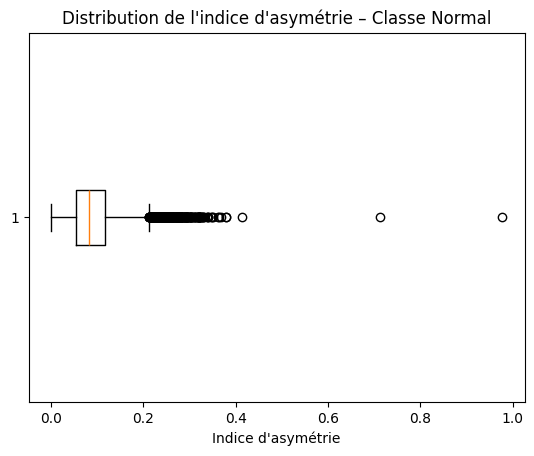

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot(normal_asymmetry, vert=False)
plt.xlabel("Indice d'asymétrie")
plt.title("Distribution de l'indice d'asymétrie – Classe Normal")
plt.show()

In [ ]:
def get_outlier_indices(data, clean_data):
    """Retourne les indices des outliers dans le tableau original"""
    mask_outliers = np.zeros(len(data), dtype=bool)
    mask_outliers[:] = True

    for value in clean_data:
        # Trouver l'indice de chaque valeur dans clean_data dans le tableau original
        idx = np.where(data == value)[0]
        if len(idx) > 0:
            mask_outliers[idx[0]] = False
            data = np.delete(data, idx[0])

    return np.where(mask_outliers)[0]


# Alternative plus simple : identifier les outliers directement
def find_outliers(data):
    """Retourne les indices des outliers"""
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
    return outlier_indices


# Trouver les outliers de la classe "normal"
outlier_indices_normal = find_outliers(normal_asymmetry)

print(f"Nombre total d'outliers pour la classe 'normal': {len(outlier_indices_normal)}")
print(
    f"Indices des outliers: {outlier_indices_normal[:10]}..."
)  # Affiche les 10 premiers

Nombre total d'outliers pour la classe 'normal': 343
Indices des outliers: [  2 136 227 244 245 246 250 254 260 261]...


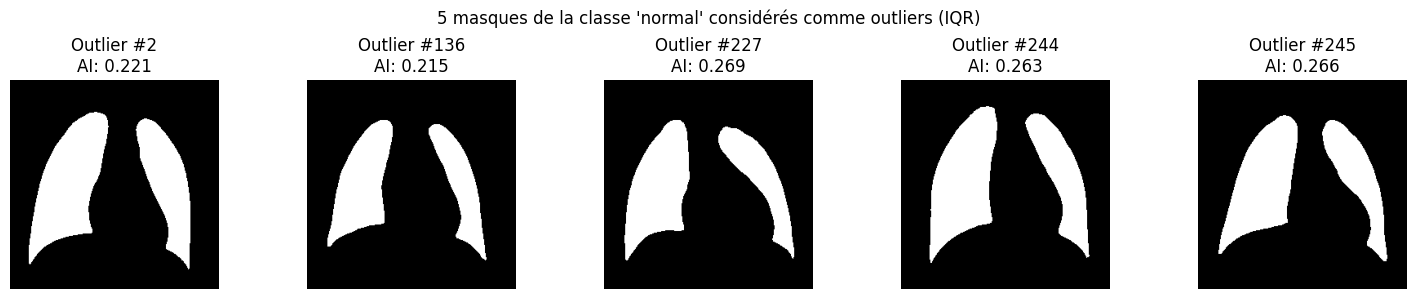

In [ ]:
# Afficher 5 des masques outliers de la classe "normal"
n_show = min(5, len(outlier_indices_normal))
fig, axes = plt.subplots(1, n_show, figsize=(15, 3))

if n_show == 1:
    axes = [axes]

for i, idx in enumerate(outlier_indices_normal[:n_show]):
    axes[i].imshow(masks["normal"][idx], cmap="gray")
    axes[i].set_title(f"Outlier #{idx}\nAI: {normal_asymmetry[idx]:.3f}")
    axes[i].axis("off")

plt.suptitle("5 masques de la classe 'normal' considérés comme outliers (IQR)")
plt.tight_layout()
plt.show()

## calculer l’indice d’asymétrie pour tous les masques de la classe covid

In [ ]:
covid_asymmetry = compute_asymmetry_for_class(masks["covid"])

In [ ]:
mean_cov_ai = np.mean(covid_asymmetry)
median_cov_ai = np.median(covid_asymmetry)
std_cov_ai = np.std(covid_asymmetry)
min_cov_ai = np.min(covid_asymmetry)
max_cov_ai = np.max(covid_asymmetry)

print(f"Moyenne : {mean_cov_ai:.3f}")
print(f"Médiane : {median_cov_ai:.3f}")
print(f"Écart-type : {std_cov_ai:.3f}")
print(f"Min : {min_cov_ai:.3f}")
print(f"Max : {max_cov_ai:.3f}")

Moyenne : 0.097
Médiane : 0.087
Écart-type : 0.066
Min : 0.000
Max : 0.990


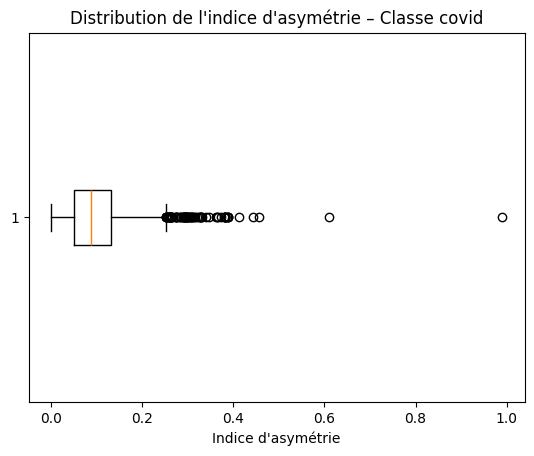

In [ ]:
plt.boxplot(covid_asymmetry, vert=False)
plt.xlabel("Indice d'asymétrie")
plt.title("Distribution de l'indice d'asymétrie – Classe covid")
plt.show()

In [ ]:
outlier_indices_covid = find_outliers(covid_asymmetry)

print(f"Nombre total d'outliers pour la classe 'covid': {len(outlier_indices_covid)}")
print(f"Indices des outliers: {outlier_indices_covid[:10]}...")

Nombre total d'outliers pour la classe 'covid': 83
Indices des outliers: [ 19  99 163 180 183 193 197 252 365 388]...


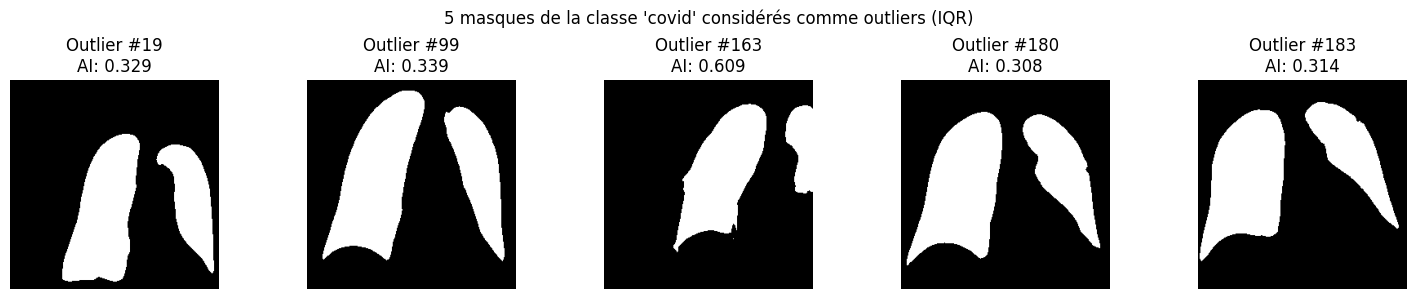

In [ ]:
n_show = min(5, len(outlier_indices_covid))
fig, axes = plt.subplots(1, n_show, figsize=(15, 3))

if n_show == 1:
    axes = [axes]

for i, idx in enumerate(outlier_indices_covid[:n_show]):
    axes[i].imshow(masks["covid"][idx], cmap="gray")
    axes[i].set_title(f"Outlier #{idx}\nAI: {covid_asymmetry[idx]:.3f}")
    axes[i].axis("off")

plt.suptitle("5 masques de la classe 'covid' considérés comme outliers (IQR)")
plt.tight_layout()
plt.show()

## calculer l’indice d’asymétrie pour tous les masques de la classe viral pneumonia

In [ ]:
viralP_asymmetry = compute_asymmetry_for_class(masks["viral_pneumonia"])

In [ ]:
mean_vp_ai = np.mean(viralP_asymmetry)
median_vp_ai = np.median(viralP_asymmetry)
std_vp_ai = np.std(viralP_asymmetry)
min_vp_ai = np.min(viralP_asymmetry)
max_vp_ai = np.max(viralP_asymmetry)
print(f"Moyenne : {mean_vp_ai:.3f}")
print(f"Médiane : {median_vp_ai:.3f}")
print(f"Écart-type : {std_vp_ai:.3f}")
print(f"Min : {min_vp_ai:.3f}")
print(f"Max : {max_vp_ai:.3f}")

Moyenne : 0.184
Médiane : 0.181
Écart-type : 0.087
Min : 0.000
Max : 0.574


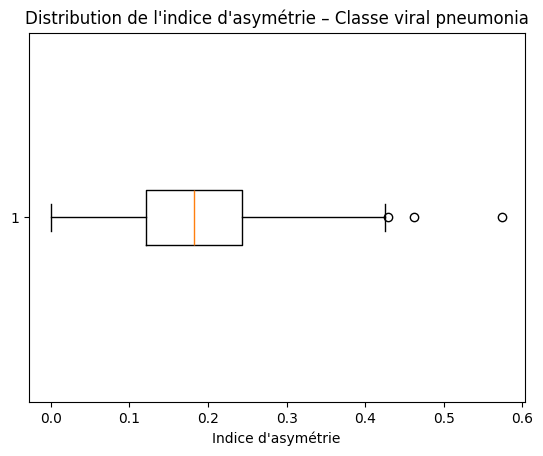

In [ ]:
plt.boxplot(viralP_asymmetry, vert=False)
plt.xlabel("Indice d'asymétrie")
plt.title("Distribution de l'indice d'asymétrie – Classe viral pneumonia")
plt.show()

In [ ]:
outlier_indices_vp = find_outliers(viralP_asymmetry)

print(f"Nombre total d'outliers pour la classe 'viralP': {len(outlier_indices_vp)}")
print(f"Indices des outliers: {outlier_indices_vp[:10]}...")

Nombre total d'outliers pour la classe 'viralP': 3
Indices des outliers: [ 482 1009 1128]...


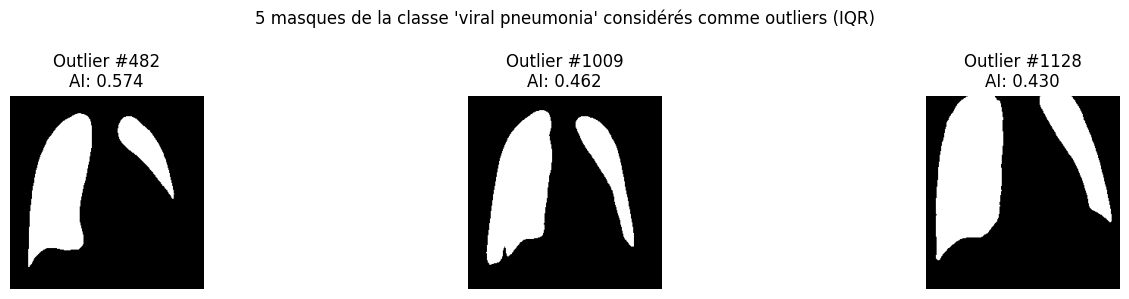

In [ ]:
n_show = min(5, len(outlier_indices_vp))
fig, axes = plt.subplots(1, n_show, figsize=(15, 3))

if n_show == 1:
    axes = [axes]

for i, idx in enumerate(outlier_indices_vp[:n_show]):
    axes[i].imshow(masks["viral_pneumonia"][idx], cmap="gray")
    axes[i].set_title(f"Outlier #{idx}\nAI: {viralP_asymmetry[idx]:.3f}")
    axes[i].axis("off")

plt.suptitle("5 masques de la classe 'viral pneumonia' considérés comme outliers (IQR)")
plt.tight_layout()
plt.show()

## calculer l’indice d’asymétrie pour tous les masques de la classe lung opacity

In [ ]:
lungOp_asymmetry = compute_asymmetry_for_class(masks["lung_opacity"])

In [ ]:
# Count how many 'lung_opacity' masks have only one region or less
single_region_count = 0
for mask in masks["lung_opacity"]:
    _, binary = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    num_labels, labels = cv2.connectedComponents(binary)
    # num_labels includes background, so <=2 means 0 or 1 region(s) (excluding background)
    if num_labels <= 2:
        single_region_count += 1
print(
    f"Number of 'lung_opacity' masks with only one region or less: {single_region_count}"
)

Number of 'lung_opacity' masks with only one region or less: 2


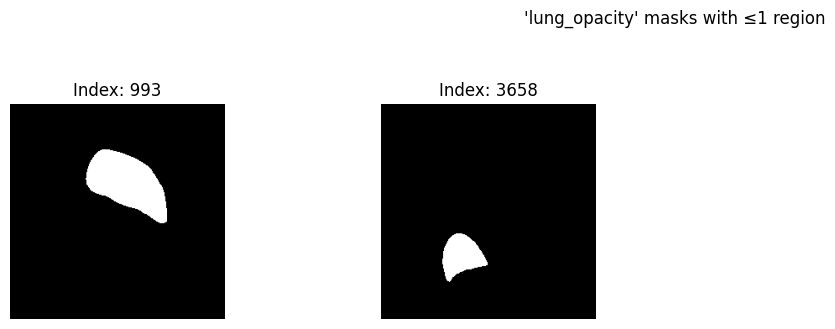

In [ ]:
# Visualize 'lung_opacity' masks with only one region or less
import matplotlib.pyplot as plt

single_region_indices = []
for idx, mask in enumerate(masks["lung_opacity"]):
    _, binary = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    num_labels, labels = cv2.connectedComponents(binary)
    if num_labels <= 2:
        single_region_indices.append(idx)

# Plot up to 12 such masks
n_show = min(12, len(single_region_indices))
plt.figure(figsize=(15, 8))
for i in range(n_show):
    idx = single_region_indices[i]
    plt.subplot(3, 4, i + 1)
    plt.imshow(masks["lung_opacity"][idx], cmap="gray")
    plt.title(f"Index: {idx}")
    plt.axis("off")
plt.suptitle("'lung_opacity' masks with ≤1 region")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
mean_lo_ai = np.mean(lungOp_asymmetry)
median_lo_ai = np.median(lungOp_asymmetry)
std_lo_ai = np.std(lungOp_asymmetry)
min_lo_ai = np.min(lungOp_asymmetry)
max_lo_ai = np.max(lungOp_asymmetry)
print(f"Moyenne : {mean_lo_ai:.3f}")
print(f"Médiane : {median_lo_ai:.3f}")
print(f"Écart-type : {std_lo_ai:.3f}")
print(f"Min : {min_lo_ai:.3f}")
print(f"Max : {max_lo_ai:.3f}")

Moyenne : 0.122
Médiane : 0.110
Écart-type : 0.085
Min : 0.000
Max : 1.000


In [ ]:
outlier_indices_lo = find_outliers(lungOp_asymmetry)

print(f"Nombre total d'outliers pour la classe 'lungOp': {len(outlier_indices_lo)}")
print(f"Indices des outliers: {outlier_indices_lo[:10]}...")

Nombre total d'outliers pour la classe 'lungOp': 89
Indices des outliers: [162 268 313 328 332 504 572 746 799 850]...


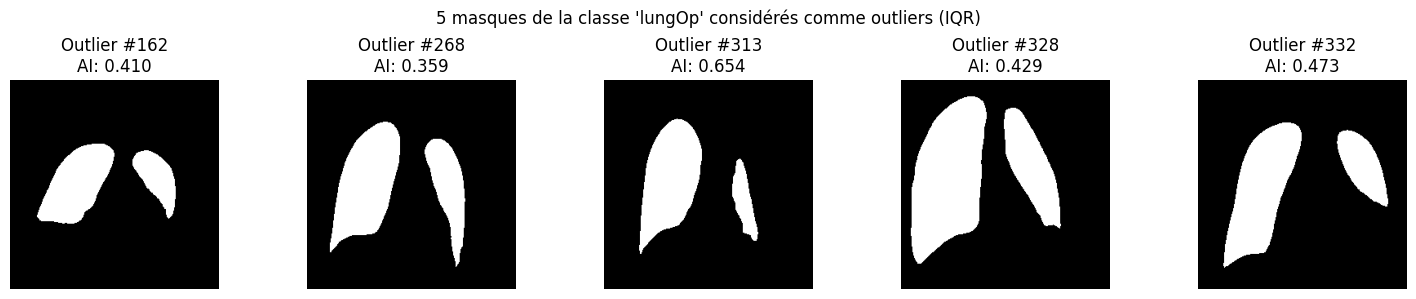

In [ ]:
n_show = min(5, len(outlier_indices_lo))
fig, axes = plt.subplots(1, n_show, figsize=(15, 3))

if n_show == 1:
    axes = [axes]

for i, idx in enumerate(outlier_indices_lo[:n_show]):
    axes[i].imshow(masks["lung_opacity"][idx], cmap="gray")
    axes[i].set_title(f"Outlier #{idx}\nAI: {lungOp_asymmetry[idx]:.3f}")
    axes[i].axis("off")

plt.suptitle("5 masques de la classe 'lungOp' considérés comme outliers (IQR)")
plt.tight_layout()
plt.show()

# Plot des box plot de toutes les classes pour le critère d'asymétrie

C:\Users\axell\AppData\Local\Temp\ipykernel_11372\3847829660.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


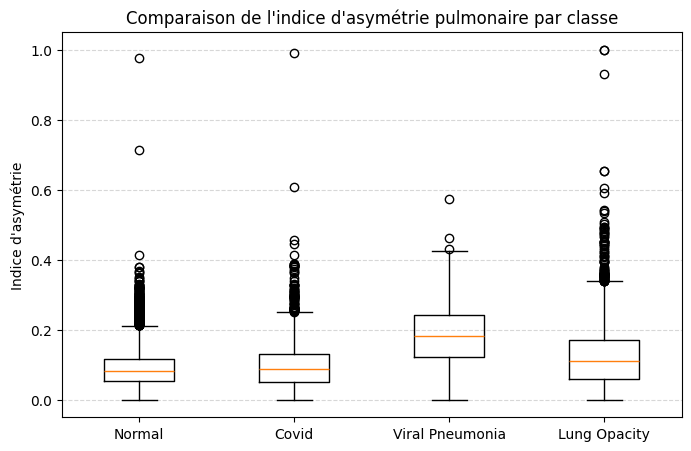

In [ ]:
data = [normal_asymmetry, covid_asymmetry, viralP_asymmetry, lungOp_asymmetry]

labels = ["Normal", "Covid", "Viral Pneumonia", "Lung Opacity"]

plt.figure(figsize=(8, 5))
plt.boxplot(data, labels=labels, showfliers=True)
plt.ylabel("Indice d'asymétrie")
plt.title("Comparaison de l'indice d'asymétrie pulmonaire par classe")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()

## Enlever les outliers

In [ ]:
import numpy as np


def remove_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return data[(data >= lower_bound) & (data <= upper_bound)]

In [ ]:
normal_clean = remove_outliers_iqr(normal_asymmetry)
covid_clean = remove_outliers_iqr(covid_asymmetry)
viralP_clean = remove_outliers_iqr(viralP_asymmetry)
lungOp_clean = remove_outliers_iqr(lungOp_asymmetry)

In [ ]:
print(f"Normal : {len(normal_asymmetry) - len(normal_clean)} outliers supprimés")
print(f"Covid : {len(covid_asymmetry) - len(covid_clean)} outliers supprimés")
print(
    f"Viral Pneumonia : {len(viralP_asymmetry) - len(viralP_clean)} outliers supprimés"
)
print(f"Lung Opacity : {len(lungOp_asymmetry) - len(lungOp_clean)} outliers supprimés")

Normal : 343 outliers supprimés
Covid : 83 outliers supprimés
Viral Pneumonia : 3 outliers supprimés
Lung Opacity : 89 outliers supprimés


C:\Users\axell\AppData\Local\Temp\ipykernel_11372\3574100915.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_clean, labels=labels, showfliers=False)


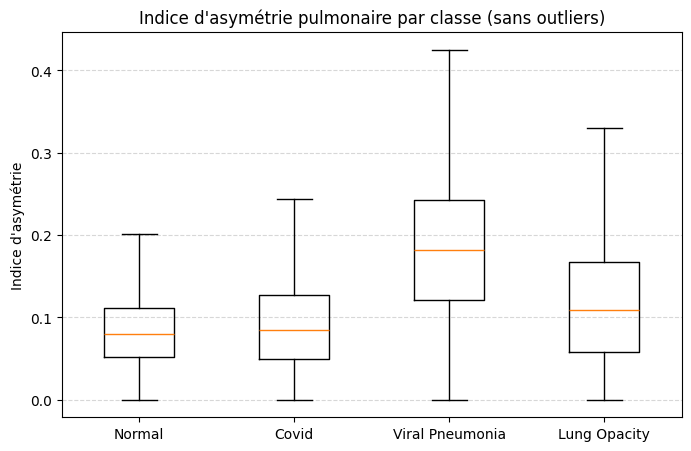

In [ ]:
import matplotlib.pyplot as plt

data_clean = [normal_clean, covid_clean, viralP_clean, lungOp_clean]

labels = ["Normal", "Covid", "Viral Pneumonia", "Lung Opacity"]

plt.figure(figsize=(8, 5))
plt.boxplot(data_clean, labels=labels, showfliers=False)
plt.ylabel("Indice d'asymétrie")
plt.title("Indice d'asymétrie pulmonaire par classe (sans outliers)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()

## observation de la position du masque

In [ ]:
def lung_out_of_frame(mask):

    mask = (mask > 0).astype(np.uint8)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        mask, connectivity=8
    )

    # Si moins de 2 composantes (hors fond)
    if num_labels < 3:
        return False

    areas = stats[1:, cv2.CC_STAT_AREA]
    largest_indices = np.argsort(areas)[-2:] + 1

    for idx in largest_indices:
        component_mask = labels == idx

        touches_border = (
            np.any(component_mask[0, :])
            or np.any(component_mask[-1, :])
            or np.any(component_mask[:, 0])
            or np.any(component_mask[:, -1])
        )

        if touches_border:
            return True

    return False

In [ ]:
def check_lung_by_class(mask_list):
    """
    Retourne la liste des indices des masques
    dont au moins un poumon sort du cadre.
    """

    out_of_frame_indices = []

    for i, mask in enumerate(mask_list):
        if lung_out_of_frame(mask):
            out_of_frame_indices.append(i)

    return out_of_frame_indices

In [ ]:
lungs_covid = check_lung_by_class(masks["covid"])

In [ ]:
print("out of frame covid:", len(lungs_covid))

out of frame covid: 381


In [ ]:
lungs_normal = check_lung_by_class(masks["normal"])
print("out of frame  normal:", len(lungs_normal))
lungs_viral = check_lung_by_class(masks["viral_pneumonia"])
print("out of frame vp:", len(lungs_viral))
lungs_lungOp = check_lung_by_class(masks["lung_opacity"])
print("out of frame lungOp:", len(lungs_lungOp))

out of frame  normal: 233
out of frame vp: 195
out of frame lungOp: 294


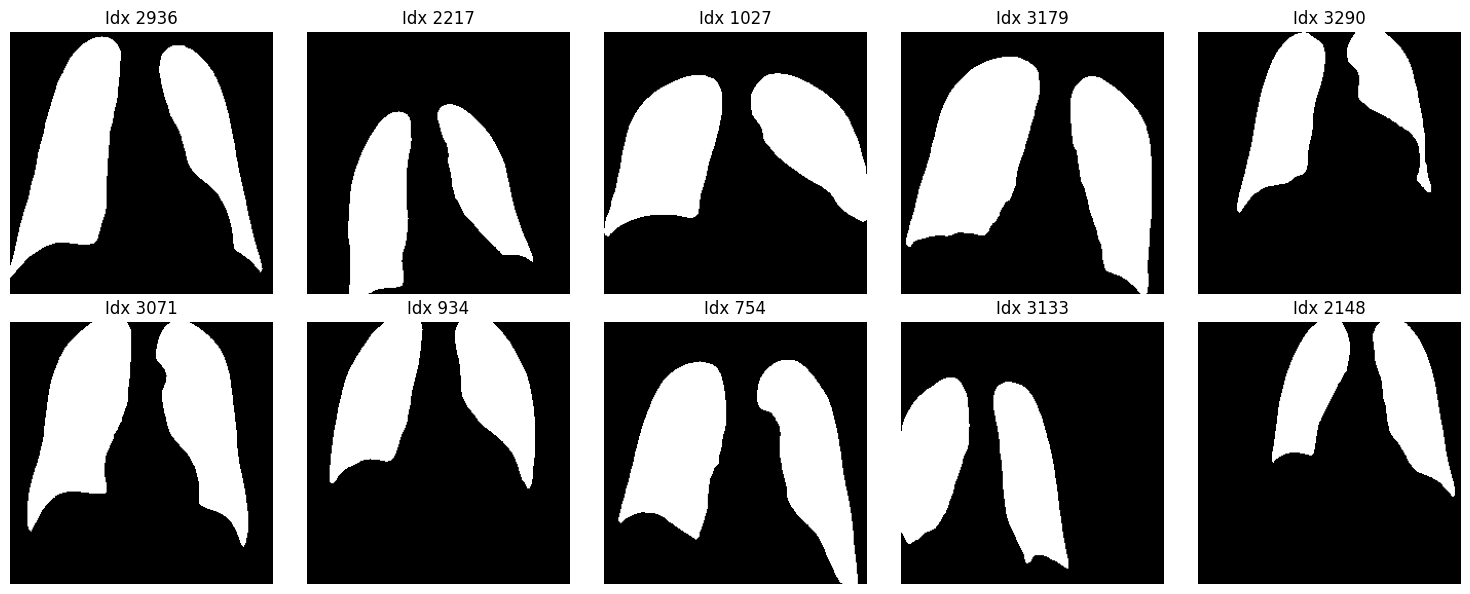

In [ ]:
import random
import matplotlib.pyplot as plt
import math

n_display = min(10, len(lungs_covid))
random_indices = random.sample(lungs_covid, n_display)

n_cols = 5
n_rows = math.ceil(n_display / n_cols)

plt.figure(figsize=(15, 3 * n_rows))

for i, idx in enumerate(random_indices):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(masks["covid"][idx], cmap="gray")
    plt.title(f"Idx {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### création d'un nouveau dictionnaire sans les masques où les poumons sortent du cadre

In [ ]:
masks_b = {}

for classe, mask_list in masks.items():
    good_masks = []

    for mask in mask_list:
        if not lung_out_of_frame(mask):
            good_masks.append(mask)

    masks_b[classe] = good_masks

### calcul des asymétries sans les images qui débordent

In [ ]:
normal_asymmetry_b = compute_asymmetry_for_class(masks_b["normal"])
covid_asymmetry_b = compute_asymmetry_for_class(masks_b["covid"])
viralP_asymmetry_b = compute_asymmetry_for_class(masks_b["viral_pneumonia"])
lungOp_asymmetry_b = compute_asymmetry_for_class(masks_b["lung_opacity"])

In [ ]:
outlier_indices_normal_b = find_outliers(normal_asymmetry_b)
print(
    f"Nombre total d'outliers pour la classe 'normal': {len(outlier_indices_normal_b)}"
)
outlier_indices_covid_b = find_outliers(covid_asymmetry_b)
print(f"Nombre total d'outliers pour la classe 'covid': {len(outlier_indices_covid_b)}")
outlier_indices_vp_b = find_outliers(viralP_asymmetry_b)
print(f"Nombre total d'outliers pour la classe 'viralP': {len(outlier_indices_vp_b)}")
outlier_indices_lo_b = find_outliers(lungOp_asymmetry_b)
print(f"Nombre total d'outliers pour la classe 'lungOp': {len(outlier_indices_lo_b)}")

Nombre total d'outliers pour la classe 'normal': 335
Nombre total d'outliers pour la classe 'covid': 71
Nombre total d'outliers pour la classe 'viralP': 2
Nombre total d'outliers pour la classe 'lungOp': 82


C:\Users\axell\AppData\Local\Temp\ipykernel_4008\934767256.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


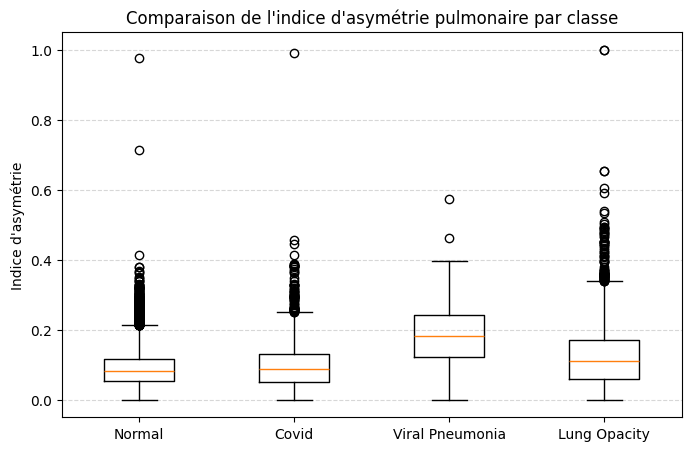

In [ ]:
data = [normal_asymmetry_b, covid_asymmetry_b, viralP_asymmetry_b, lungOp_asymmetry_b]

labels = ["Normal", "Covid", "Viral Pneumonia", "Lung Opacity"]

plt.figure(figsize=(8, 5))
plt.boxplot(data, labels=labels, showfliers=True)
plt.ylabel("Indice d'asymétrie")
plt.title("Comparaison de l'indice d'asymétrie pulmonaire par classe")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()

#### on remarque une légère différence avec le box plot précédent, ce qui signifi que certains des masques considérés que outliers par l'indices d'asymétries etaient des masques avec des poumons mal centrés